## Pakete

In [ ]:
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

## Allgemeine Information zum Datensatz

In [2]:
# df holen
#import pandas as pd
#davor muss mittels `os` die directory über dem `src` für die Daten und Ergebnisse angeheftet werden
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


aids = pd.read_csv('data/aids.csv', sep =",")

In [3]:
aids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   num      2139 non-null   int64  
 1   time     2139 non-null   int64  
 2   trt      2139 non-null   int64  
 3   age      2139 non-null   int64  
 4   wtkg     2139 non-null   float64
 5   hemo     2139 non-null   int64  
 6   homo     2139 non-null   int64  
 7   drugs    2139 non-null   int64  
 8   karnof   2139 non-null   int64  
 9   oprior   2139 non-null   int64  
 10  z30      2139 non-null   int64  
 11  zprior   2139 non-null   int64  
 12  preanti  2139 non-null   int64  
 13  race     2139 non-null   int64  
 14  gender   2139 non-null   int64  
 15  str2     2139 non-null   int64  
 16  strat    2139 non-null   int64  
 17  symptom  2139 non-null   int64  
 18  treat    2139 non-null   int64  
 19  offtrt   2139 non-null   int64  
 20  cd40     2139 non-null   int64  
 21  cd420    2139 

## Dictionary für das Labeling erstellen

Die Beschreibung einzelner Features befindet sich im `README`. Es werden Labels für kategoriale Features erstellt. Die Information in den Features liegt numerisch vor. Es muss kein Replacement in den Daten erfolgen.

In [3]:
trt_dict = {0: 'ZDV only', 1: 'ZDV + ddI', 2: 'ZDV + Zal', 3: 'ddI only'}
hemo_dict = {0: 'no hemophilia', 1: 'hemophilia'}
homo_dict = {0: 'no homosexual', 1: 'homosexual'}
drugs_dict = {0: 'no IV drugs use', 1: 'IV drugs use'}
oprior_dict = {0: 'no prior antiretroviral therapy (no ZDV)', 1: 'prior antiretroviral therapy (no ZDV)'}
z30_dict = {0: 'no ZDV-Therapy 30 days befor randomisation', 1: 'ZDV-Therapy 30 days befor randomisation'}
zprior_dict = {0: 'no ZDV-Therapy befor randomisation', 1: 'ZDV-Therapy befor randomisation'}
race_dict = {0: 'White', 1: 'Non-White'}
gender_dict = {0: 'Female', 1: 'Male'}
str2_dict = {0: 'naive', 1: 'experienced'}
strat_dict = {1: 'Antiretroviral Naive', 2: '> 1 but <= 52 weeks of prior antiretroviral therapy', 3: '> 52 weeks'}
symptom_dict = {0: 'asymptomatic', 1: 'symtomatic'}
treat_dict = {0: 'ZDV only', 1: 'others'}
offtrt_dict = {0: "no off trt befor 96 weeks",1: "off trt befor 96 weeks"}
cid_dict = {0: 'censoring', 1: 'failure'}


## Die Betrachtung von kontinuerlichen und kategorialen Features

Da die Daten allesamt numerisch vorliegen, wird der `Dtype` *int64* anhand der formalen Kriterien automatisch auch an die kategorialen Features vergeben. D.h. die kategorialen Features wie *gender*, *treatment* oder *homosexuality* können nicht von den diskreten Features wie *age* unterschieden werden. Zum Zweck der Typisierung werden die kategorialen Features mithilfe von dem zuvor erstellten `dictionary` in den entsprechenden Datentyp konvertiert.

In [4]:
# eine Liste aller dictionary
dict1=[trt_dict,hemo_dict,homo_dict,drugs_dict, oprior_dict,z30_dict,zprior_dict,race_dict,gender_dict,str2_dict,strat_dict,symptom_dict,treat_dict,offtrt_dict,cid_dict]
len(dict1)

15

In [5]:
# eine Liste aller kategorialen Features
stri=["trt","hemo","homo","drugs","oprior","z30","zprior","race","gender","str2","strat","symptom","treat","offtrt", "cid"]
len(stri)

15

In [6]:
# Austausch numerischer Werte auf Labels
aids[stri[0]]=aids[stri[0]].replace(dict1[0])

aids[stri[1]]=aids[stri[1]].replace(dict1[1])

aids[stri[2]]=aids[stri[2]].replace(dict1[2])

aids[stri[3]]=aids[stri[3]].replace(dict1[3])

aids[stri[4]]=aids[stri[4]].replace(dict1[4])

aids[stri[5]]=aids[stri[5]].replace(dict1[5])

aids[stri[6]]=aids[stri[6]].replace(dict1[6])

aids[stri[7]]=aids[stri[7]].replace(dict1[7])

aids[stri[8]]=aids[stri[8]].replace(dict1[8])

aids[stri[9]]=aids[stri[9]].replace(dict1[9])

aids[stri[10]]=aids[stri[10]].replace(dict1[10])

aids[stri[11]]=aids[stri[11]].replace(dict1[11])

aids[stri[12]]=aids[stri[12]].replace(dict1[12])

aids[stri[13]]=aids[stri[13]].replace(dict1[13])

aids[stri[14]]=aids[stri[14]].replace(dict1[14])

## Einfache Häufigkeiten einzelner Features

In [8]:
aids.value_counts([stri[0]])

trt      
ddI only     561
ZDV only     532
ZDV + Zal    524
ZDV + ddI    522
Name: count, dtype: int64

In [9]:
aids.value_counts([stri[1]])

hemo         
no hemophilia    1959
hemophilia        180
Name: count, dtype: int64

In [10]:
aids.value_counts([stri[2]])

homo         
homosexual       1414
no homosexual     725
Name: count, dtype: int64

In [11]:
aids.value_counts([stri[3]])

drugs          
no IV drugs use    1858
IV drugs use        281
Name: count, dtype: int64

In [12]:
aids.value_counts([stri[4]])

oprior                                  
no prior antiretroviral therapy (no ZDV)    2092
prior antiretroviral therapy (no ZDV)         47
Name: count, dtype: int64

In [13]:
aids.value_counts([stri[5]])

z30                                       
ZDV-Therapy 30 days befor randomisation       1177
no ZDV-Therapy 30 days befor randomisation     962
Name: count, dtype: int64

In [14]:
aids.value_counts([stri[6]])

zprior                         
ZDV-Therapy befor randomisation    2139
Name: count, dtype: int64

In [15]:
aids.value_counts([stri[7]])

race     
White        1522
Non-White     617
Name: count, dtype: int64

In [16]:
aids.value_counts([stri[8]])

gender
Male      1771
Female     368
Name: count, dtype: int64

In [17]:
aids.value_counts([stri[9]])

str2       
experienced    1253
naive           886
Name: count, dtype: int64

In [18]:
aids.value_counts([stri[10]])

strat                                              
Antiretroviral Naive                                   886
> 52 weeks                                             843
> 1 but <= 52 weeks of prior antiretroviral therapy    410
Name: count, dtype: int64

In [19]:
aids.value_counts([stri[11]])

symptom     
asymptomatic    1769
symtomatic       370
Name: count, dtype: int64

In [20]:
aids.value_counts([stri[12]])

treat   
others      1607
ZDV only     532
Name: count, dtype: int64

In [21]:
aids.value_counts([stri[13]])

offtrt                   
no off trt befor 96 weeks    1363
off trt befor 96 weeks        776
Name: count, dtype: int64

In [22]:
aids.value_counts([stri[14]])

cid      
censoring    1618
failure       521
Name: count, dtype: int64

In [23]:
aids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   num      2139 non-null   int64  
 1   time     2139 non-null   int64  
 2   trt      2139 non-null   object 
 3   age      2139 non-null   int64  
 4   wtkg     2139 non-null   float64
 5   hemo     2139 non-null   object 
 6   homo     2139 non-null   object 
 7   drugs    2139 non-null   object 
 8   karnof   2139 non-null   int64  
 9   oprior   2139 non-null   object 
 10  z30      2139 non-null   object 
 11  zprior   2139 non-null   object 
 12  preanti  2139 non-null   int64  
 13  race     2139 non-null   object 
 14  gender   2139 non-null   object 
 15  str2     2139 non-null   object 
 16  strat    2139 non-null   object 
 17  symptom  2139 non-null   object 
 18  treat    2139 non-null   object 
 19  offtrt   2139 non-null   object 
 20  cd40     2139 non-null   int64  
 21  cd420    2139 

#Datentyp umkonvertieren
aids=aids.convert_dtypes()
aids.info()

Diese Datentyp-Konvertirung ergibt aufgeräumte Zahlen und präzise Typisierung der *string*-Features. Jedoch ist sie SEHR sperrig im DataFrame-Handing. Daher sehe ich davon ab.

In [7]:
# einen temporären Datensatz mit kontinuerlichen Features erstellen
aidsnum = aids.drop(stri,axis=1)
aidsnum.shape

aidsnum.columns

Index(['num', 'time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420',
       'cd80', 'cd820'],
      dtype='object')

In [ ]:
# für weitere Tables ID-Nummerierung enfernen
aidsnum = aidsnum.drop(["num"],axis=1)

In [10]:
aidsnum.info() #check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     2139 non-null   int64  
 1   age      2139 non-null   int64  
 2   wtkg     2139 non-null   float64
 3   karnof   2139 non-null   int64  
 4   preanti  2139 non-null   int64  
 5   cd40     2139 non-null   int64  
 6   cd420    2139 non-null   int64  
 7   cd80     2139 non-null   int64  
 8   cd820    2139 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 150.5 KB


## Explorative Analyse

In [11]:
aidsnum.describe(include="all")

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,35.248247,75.125311,95.446470,379.175783,350.501169,371.307153,986.627396,935.369799
std,292.274324,8.709026,13.263164,5.900985,468.657526,118.573863,144.634909,480.197750,444.976051
min,14.000000,12.000000,31.000000,70.000000,0.000000,0.000000,49.000000,40.000000,124.000000
25%,727.000000,29.000000,66.679200,90.000000,0.000000,263.500000,269.000000,654.000000,631.500000
50%,997.000000,34.000000,74.390400,100.000000,142.000000,340.000000,353.000000,893.000000,865.000000
75%,1091.000000,40.000000,82.555200,100.000000,739.500000,423.000000,460.000000,1207.000000,1146.500000
max,1231.000000,70.000000,159.939360,100.000000,2851.000000,1199.000000,1119.000000,5011.000000,6035.000000


## Korrelationsmatrix

In [12]:
corrma = aidsnum.corr()
corrma.style.background_gradient(cmap='coolwarm')

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
time,1.000000,0.026544,0.009225,0.094417,0.007249,0.191436,0.350611,-0.017425,0.032480
age,0.026544,1.000000,0.132858,-0.100041,0.113220,-0.040302,-0.044294,0.046874,0.037458
wtkg,0.009225,0.132858,1.000000,0.034271,-0.079292,0.036401,0.020980,0.090075,0.085447
karnof,0.094417,-0.100041,0.034271,1.000000,-0.023189,0.077730,0.098463,-0.008567,-0.003981
preanti,0.007249,0.113220,-0.079292,-0.023189,1.000000,-0.067495,-0.132213,0.037500,0.023221
cd40,0.191436,-0.040302,0.036401,0.077730,-0.067495,1.000000,0.583578,0.214274,0.073039
cd420,0.350611,-0.044294,0.020980,0.098463,-0.132213,0.583578,1.000000,0.054165,0.216472
cd80,-0.017425,0.046874,0.090075,-0.008567,0.037500,0.214274,0.054165,1.000000,0.756218
cd820,0.032480,0.037458,0.085447,-0.003981,0.023221,0.073039,0.216472,0.756218,1.000000


<Axes: xlabel='age', ylabel='karnof'>

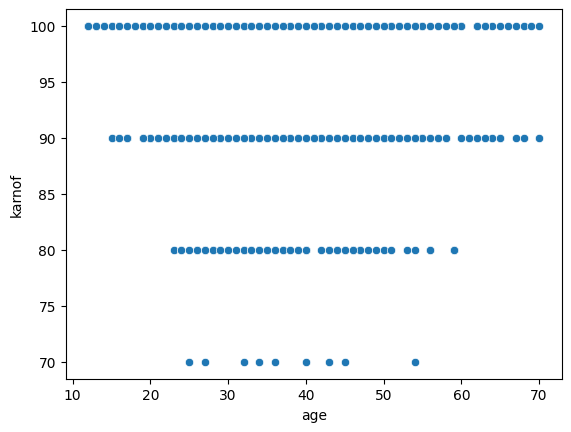

In [13]:
# scatter-plot für Alter und Karnofsky-Index (Score für den allgemeinen Zustand)
sns.scatterplot(aidsnum, x='age', y='karnof')

In [14]:
# der Karnofsky-Score scheint als ein kategorialer Feature erhoben worden zu sein. 
# Theoretisch ist der Score eine Skala von 0 bis 100.
aidsnum.value_counts(["karnof"])

karnof
100       1263
90         787
80          80
70           9
Name: count, dtype: int64

In [11]:
# Operationalisierung des Karnofsky-Scores im Main-Datensatz
karnof_dict = {70: '70%', 80: '80%', 90: '90%', 100: '100%'}

#HInzufügen des neuen dictionary zu der dict-liste
dict1.append(karnof_dict)

#Hinzufügen des Features zu der Liste der `strings`
stri.append("karnof")

len(dict1) #check, sollte nun 16 sein

16

In [12]:
dict1

[{0: 'ZDV only', 1: 'ZDV + ddI', 2: 'ZDV + Zal', 3: 'ddI only'},
 {0: 'no hemophilia', 1: 'hemophilia'},
 {0: 'no homosexual', 1: 'homosexual'},
 {0: 'no IV drugs use', 1: 'IV drugs use'},
 {0: 'no prior antiretroviral therapy (no ZDV)',
  1: 'prior antiretroviral therapy (no ZDV)'},
 {0: 'no ZDV-Therapy 30 days befor randomisation',
  1: 'ZDV-Therapy 30 days befor randomisation'},
 {0: 'no ZDV-Therapy befor randomisation',
  1: 'ZDV-Therapy befor randomisation'},
 {0: 'White', 1: 'Non-White'},
 {0: 'Female', 1: 'Male'},
 {0: 'naive', 1: 'experienced'},
 {1: 'Antiretroviral Naive',
  2: '> 1 but <= 52 weeks of prior antiretroviral therapy',
  3: '> 52 weeks'},
 {0: 'asymptomatic', 1: 'symtomatic'},
 {0: 'ZDV only', 1: 'others'},
 {0: 'no off trt befor 96 weeks', 1: 'off trt befor 96 weeks'},
 {0: 'censoring', 1: 'failure'},
 {70: '70%', 80: '80%', 90: '90%', 100: '100%'}]

In [13]:
len(stri)

16

In [14]:

aids[stri[15]]=aids[stri[15]].replace(dict1[15])

aids.value_counts([stri[15]])

karnof
100%      1263
90%        787
80%         80
70%          9
Name: count, dtype: int64

<Axes: xlabel='wtkg', ylabel='preanti'>

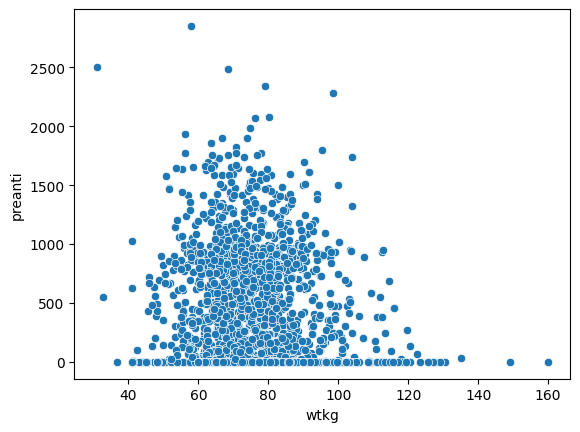

In [20]:
# scatter-plot für Gewicht at baseline und Zeit der vorigen Antiretroviralen Behandlung
sns.scatterplot(aidsnum, x='wtkg', y='preanti')

<Axes: xlabel='cd40', ylabel='cd80'>

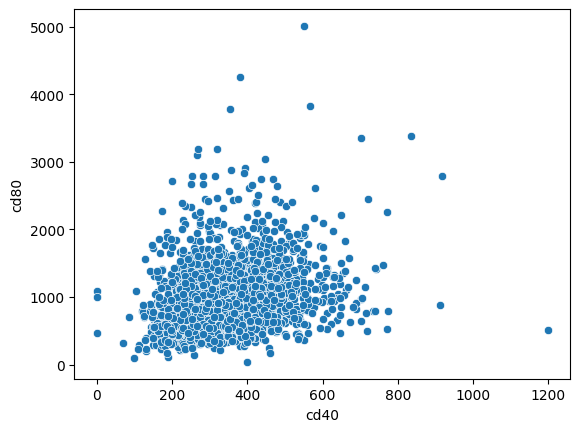

In [21]:
#cd80, cd80 scatter-plot der CD-Proteine at baseline
sns.scatterplot(aidsnum, x='cd40', y='cd80')


<Axes: xlabel='cd40', ylabel='cd420'>

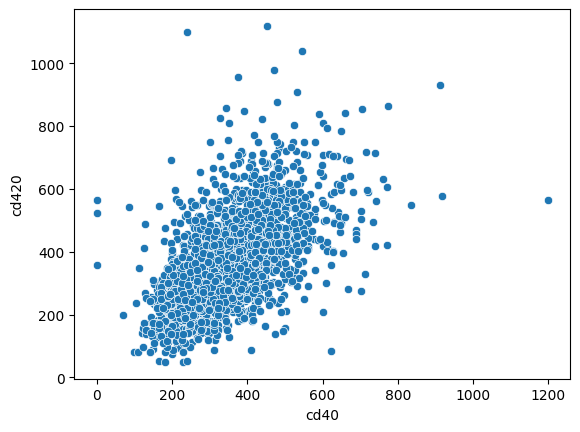

In [22]:
# CD4 at baseline udn 20 Wochen später
sns.scatterplot(aidsnum, x='cd40', y='cd420')

<Axes: xlabel='cd80', ylabel='cd820'>

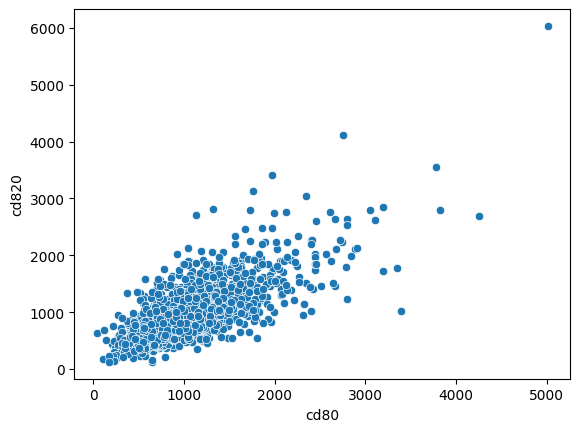

In [23]:
# CD8 at baseline udn 20 Wochen später
sns.scatterplot(aidsnum, x='cd80', y='cd820')

Es lohnt sich den CD-Marker im Verlauf für die Prädiktion zu behalten. Allerdings zeigen beide Marker CD4 und CD8 Anhängigkeiten bei Messpunkten at baseline und 20 Wochen später. Um dies zu umgehen wird je Marker ein neues Feature der Differenz zwischen dem Zeitpunkt *nach 20 Wochen* und *at baseline* erstellt. <span style="color:red"> Eventuell bekomme ich ein **Problem** mit negativen Differenzen. </span> 

Oder es kann ein CD4/CD8-Ratio gebildet werden. 

<span style="color:green">**NOTE:**</span> What is the normal CD4 count for a healthy person?
The CD4 cell count of a person who does not have HIV can be anything between 500 and 1500. People living with HIV who have a CD4 count over 500 are usually in pretty good health. People living with HIV who have a CD4 cell count below 200 are at high risk of developing serious illnesses.

## CD4

In [16]:
aids["cd4-diff"] = (aids["cd420"]-aids["cd40"])

In [20]:
np.min(aids["cd4-diff"])

np.int64(-634)

In [21]:
np.median(aids["cd4-diff"])

np.float64(13.0)

In [23]:
np.max(aids["cd4-diff"])

np.int64(860)

Text(0.5, 0, 'CD4 nach 20 Wochen - CD4 at baseline')

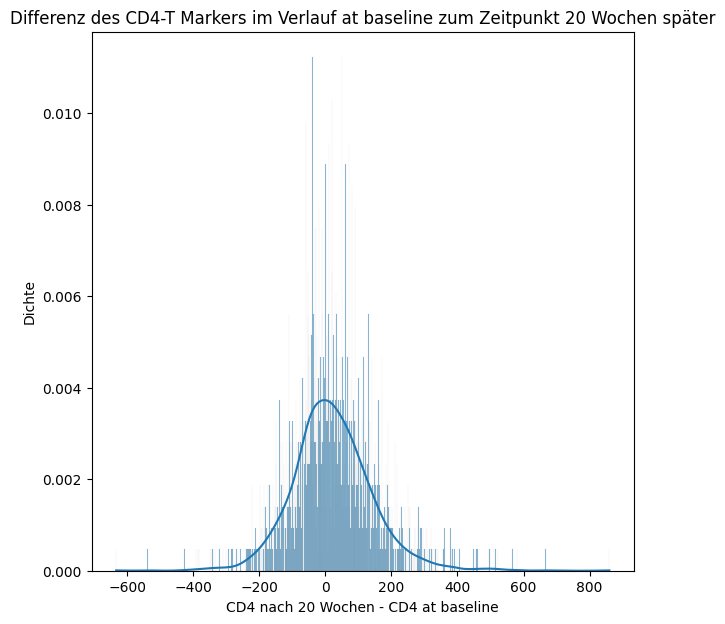

In [24]:
plt.figure(figsize=(7,7))
plot1 = sns.histplot(aids['cd4-diff'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot1.set_title("Differenz des CD4-T Markers im Verlauf at baseline zum Zeitpunkt 20 Wochen später", fontsize=12) # Beschriftungen aus pyplot
plot1.set_ylabel("Dichte", fontsize=10)
plot1.set_xlabel("CD4 nach 20 Wochen - CD4 at baseline", fontsize=10)

Text(0.5, 0, 'CD4-T')

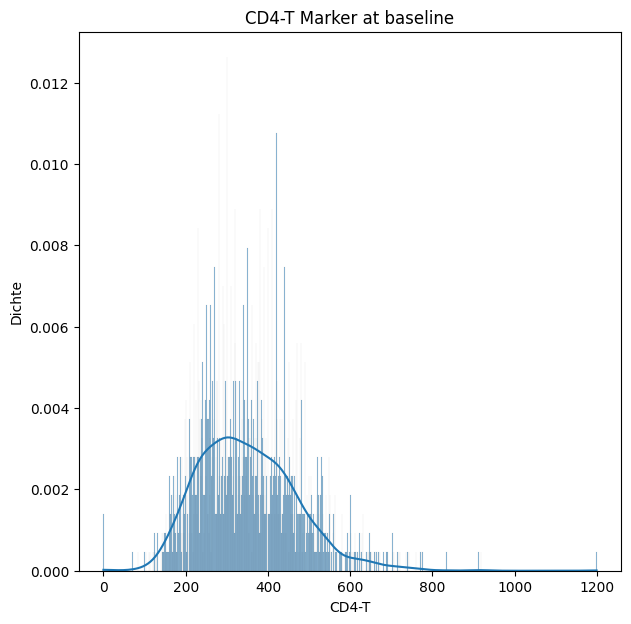

In [25]:
plt.figure(figsize=(7,7))
plot2 = sns.histplot(aids['cd40'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot2.set_title("CD4-T Marker at baseline", fontsize=12) # Beschriftungen aus pyplot
plot2.set_ylabel("Dichte", fontsize=10)
plot2.set_xlabel("CD4-T", fontsize=10)

Text(0.5, 0, 'CD4-T')

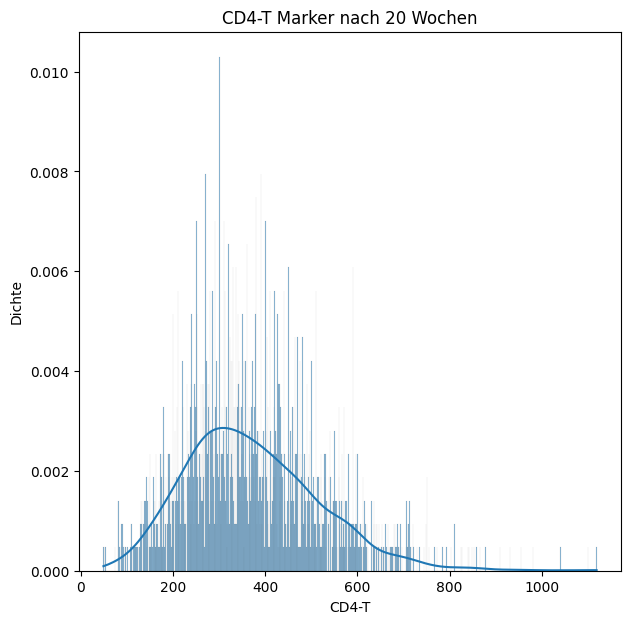

In [26]:
plt.figure(figsize=(7,7))
plot3 = sns.histplot(aids['cd420'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot3.set_title("CD4-T Marker nach 20 Wochen", fontsize=12) # Beschriftungen aus pyplot
plot3.set_ylabel("Dichte", fontsize=10)
plot3.set_xlabel("CD4-T", fontsize=10)

## CD8

In [27]:
aids["cd8-diff"] = (aids["cd820"]-aids["cd80"])

Text(0.5, 0, 'CD8 nach 20 Wochen - CD8 at baseline')

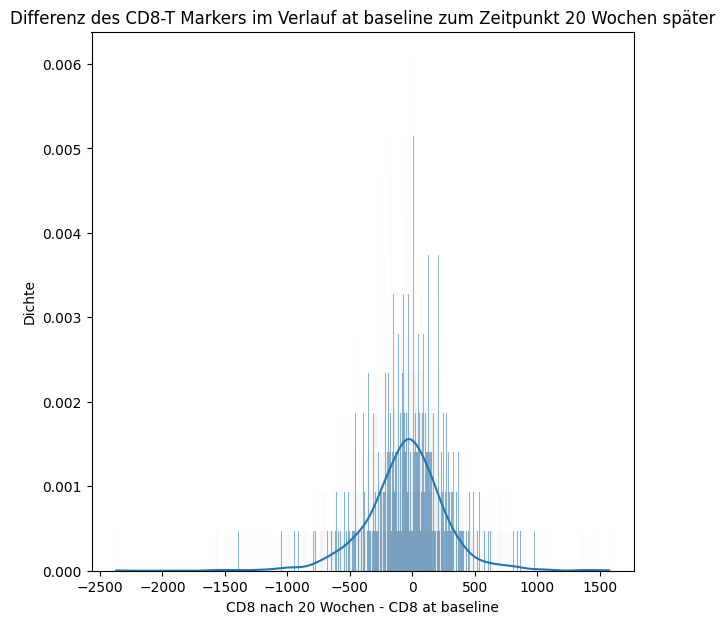

In [28]:
plt.figure(figsize=(7,7))
plot4 = sns.histplot(aids['cd8-diff'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot4.set_title("Differenz des CD8-T Markers im Verlauf at baseline zum Zeitpunkt 20 Wochen später", fontsize=12) # Beschriftungen aus pyplot
plot4.set_ylabel("Dichte", fontsize=10)
plot4.set_xlabel("CD8 nach 20 Wochen - CD8 at baseline", fontsize=10)

CD8 scheint stärker auf den Krankheitsverlauf zu reagieren. Die Differenz streut im Vergleich zum CD4 viel breiter und wird eher negativ. 

## CD4 : CD8 Ratio

<span style="color:green">**NOTE:**</span> A normal CD4/CD8 ratio is **greater than 1.0**, with CD4 lymphocytes ranging from 500 to 1200/mm 3 and CD8 lymphocytes ranging from 150 to 1000/mm 3. If your ratio is higher than 1, it means your immune system is strong and you may not have HIV.

In [36]:
aids["cd4-8-ratio"] = (aids["cd40"]/aids["cd80"])

Text(0.5, 0, 'CD4:CD8')

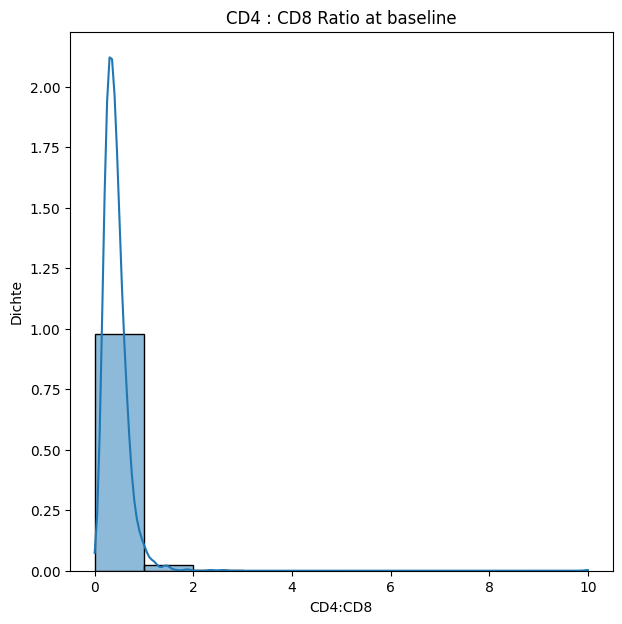

In [37]:
plt.figure(figsize=(7,7))
plot5 = sns.histplot(aids['cd4-8-ratio'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot5.set_title("CD4 : CD8 Ratio at baseline", fontsize=12) # Beschriftungen aus pyplot
plot5.set_ylabel("Dichte", fontsize=10)
plot5.set_xlabel("CD4:CD8", fontsize=10)

## Karnofsky und antiretrovirale Therapie

Text(0.5, 0, 'Karnofsky-Score at baseline')

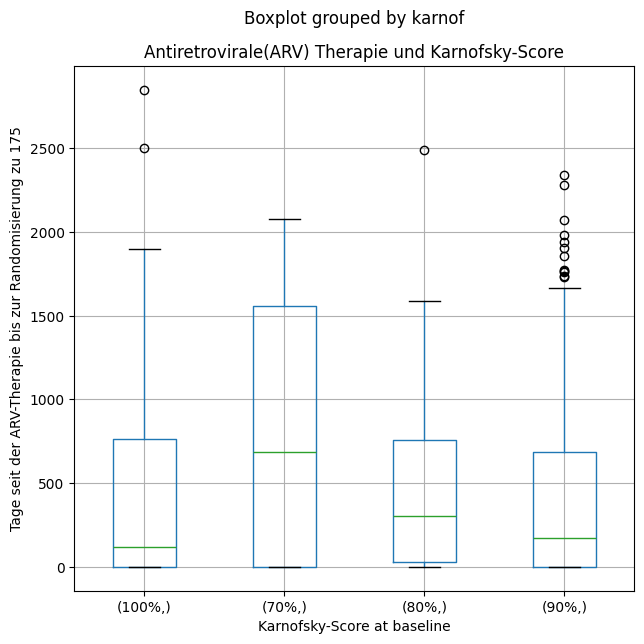

In [ ]:
plot6 = aids.boxplot(['preanti'], by=['karnof'], figsize=(7,7), return_type='both') #

plt.title("Antiretrovirale(ARV) Therapie und Karnofsky-Score", fontsize=12)
plt.ylabel("Tage seit der ARV-Therapie bis zur Randomisierung zu 175", fontsize=10)
plt.xlabel("Karnofsky-Score at baseline", fontsize=10)

## Karnofski und Zeit bis zum Outcome

Text(0.5, 0, 'Karnofsky-Score at baseline')

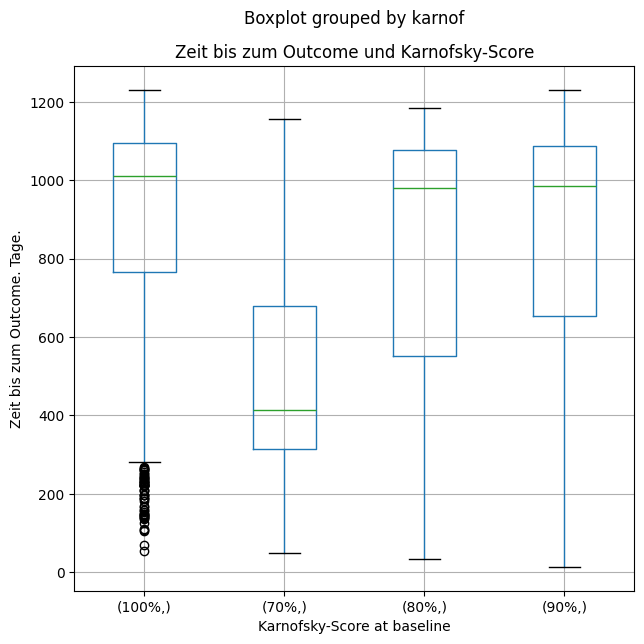

In [ ]:
plot7 = aids.boxplot(['time'], by=['karnof'], figsize=(7,7), return_type='both') #

plt.title("Zeit bis zum Outcome und Karnofsky-Score", fontsize=12)
plt.ylabel("Zeit bis zum Outcome. Tage.", fontsize=10)
plt.xlabel("Karnofsky-Score at baseline", fontsize=10)

Es scheint, dass nur Karvofsky <= 70% Einfluss auf die Zeit bis zum Outcome hat.

## Race und Zeit bis zum outcome

Text(0.5, 0, 'Ethnie')

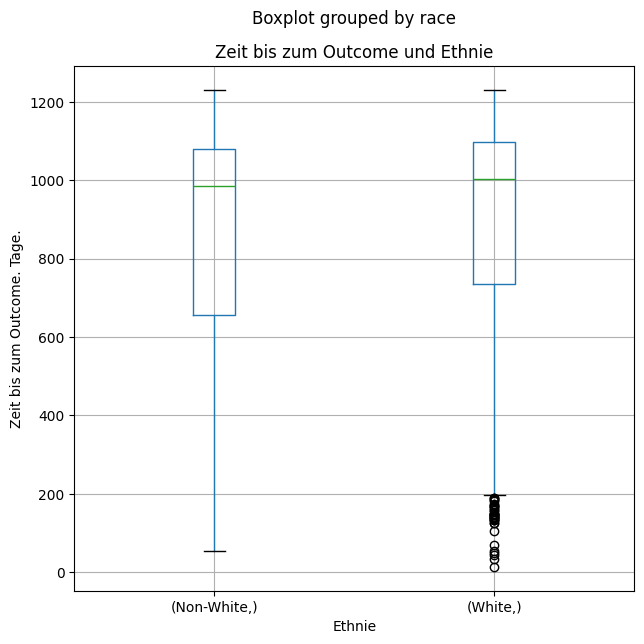

In [ ]:
plot8 = aids.boxplot(['time'], by=['race'], figsize=(7,7), return_type='both') #

plt.title("Zeit bis zum Outcome und Ethnie", fontsize=12)
plt.ylabel("Zeit bis zum Outcome. Tage.", fontsize=10)
plt.xlabel("Ethnie", fontsize=10)

## Confusion Matrix

In diesem Teil werden die kategorialen Features auf die möglichen Abhängigkeiten untereinander gepfüft.

In [5]:
var1 = aids["hemo"].replace(hemo_dict)
var2 = aids["homo"].replace(homo_dict)
v1 = pd.Series(var1,name="Hemophilia")
v2 = pd.Series(var2, name="Homosexuality")
df_confusion = pd.crosstab(v1, v2, margins=False) 
# wenn margins=True ist, werden noch die Zeilensummen ausgegeben = keine 2x2 Tabelle mehr.
df_confusion

Homosexuality,homosexual,no homosexual
Hemophilia,,
hemophilia,9,171
no hemophilia,1405,554


In [7]:
from scipy import stats
oddsratio, pvalue = stats.fisher_exact(df_confusion)
print("Odds-Ratio:", oddsratio, "p-value:", pvalue)

Odds-Ratio: 0.02075294999063495 p-value: 3.669612705132406e-74
